
# Artifact Evaluation

> #### Optimizing Deep Learning Inference via Global Analysis and Tensor Expressions

Optimizing deep neural network (DNN) execution is impor- tant but becomes increasingly difficult as DNN complexity grows. Existing DNN compilers cannot effectively exploit op- timization opportunities across operator boundaries, leaving room for improvement. To address this challenge, we present Souffle, an open-source compiler that optimizes DNN in- ference across operator boundaries. Souffle creates a global tensor dependency graph using tensor expressions, traces data flow and tensor information, and partitions the compu- tation graph into subprograms based on dataflow analysis and resource constraints. Within a subprogram, Souffle per- forms local optimization via semantic-preserving transfor- mations, finds an optimized program schedule, and improves instruction-level parallelism and data reuse. We evaluated Souffle using six representative DNN models on an NVIDIA A100 GPU. Experimental results show that Souffle consis- tently outperforms six state-of-the-art DNN optimizers by 
delivering a geometric mean speedup of up to $3.7\times$ over TensorRT and $7.8\times$ over Tensorflow XLA.

## Preliminaries
This repository showcases the performance evaluation and comparison between `Souffle`(Our work) and the existing state-of-the-art compilers/frameworks(including `XLA`, `TensorRT`, `Rammer`, `Apollo` and `IREE`).

- **XLA(Tensorflow v2.10)**: The TensorFlow XLA compiler
can fuse DNN operators like point-wise and reduction op-
erators and performs optimizations on the fused operator.
Unlike Souffle that performs analysis and optimizations on
TEs, XLA performs analysis on its high-level operators(HLO)

- **TensorRT(v8.2)**:This GPU-vendor-specific framework optimizes the inference of DNNs on NVIDIA GPUs

- **Rammer(v0.4)**:This DNN compiler is also known as NNFu-
sion. It generates a spatial-temporal schedule at compile
time to minimize scheduling overhead and exploit hardware
parallelism through inter- and intra-operator co-scheduling

- **Apollo**:This represents the state-of-the-art fusion framework for inference optimization. Apollo considers both
memory- and compute-bound tensor operators for kernel
fusions and uses hand-crafted rules to exploit parallelism
between independent tensor operators

- **IREE**:The intermediate resentation execution environment (IREE) builds upon the
LLVM MLIR project. IREE is designed to lower DNN
models to MLIR dialects to optimize model inference. IREE
utilizes the linalg dialect to perform the operator fusion,
which supports loop affine fusion optimization and global
analysis.

The metric assesed in this notebook mainly include end-to-end latency, global memory access and number of kernels.

## Important Notes
**A few bash scripts take more than half an hour to complete; Please wait for the results before executing the next one.**
**I will also provide a online jupyter notebook if you are inconvenient or having troubles  to build the environment. The jupyter notebook is run on our server and you can directly access the notebook and run the experiments from the internet**
### Links to The Paper

**For each step, we highlight that the current evaluation is corresponding to which Section or Figure in the submitted paper.**
The main restuls presented in this repository correspond to the submitted paper's Table 3, 4, 5 and Figure 6.


## 1. Experimental Environments Setup

We have setup the experiment environments on our machine.
For more info about how to setup on you local machine, please refer to `README.md`

### Check the status of docker containers

In [45]:
!docker ps

CONTAINER ID   IMAGE                                      COMMAND                  CREATED        STATUS        PORTS                NAMES
71c749bdcc48   souffle-iree:latest                        "/opt/nvidia/nvidia_…"   9 days ago     Up 9 days     6006/tcp, 8888/tcp   crazy_payne
d7bb5016ebae   souffle-tensorrt8.4.1-ubuntu18.04:latest   "/opt/nvidia/nvidia_…"   9 days ago     Up 9 days                          zen_ardinghelli
80eb556e7070   souffle-tvm-0.8:latest                     "/opt/nvidia/nvidia_…"   2 weeks ago    Up 2 weeks                         objective_tesla
5a6833d4ccc7   488c0e69d5bc                               "/opt/nvidia/nvidia_…"   2 weeks ago    Up 2 weeks                         stoic_margulis
db88060d4da6   cuda_10.24                                 "bash"                   5 weeks ago    Up 2 weeks                         rammer_cuda_fuse
447fe7bfe381   ubuntu:20.04                               "/bin/bash"              3 months ago   Up 2 weeks            

You should see containers with the following image names:
* souffle-tvm-0.8:latest
* souffle-iree:latest
* souffle-tensorrt8.4.1-ubuntu18.04:latest

### Check the hardware of the server (nvidia A100 GPU)

In [69]:
!nvidia-smi

Fri Oct 27 21:34:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  On   | 00000000:D8:00.0 Off |                    0 |
| N/A   34C    P0    43W / 300W |      0MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2. Evaluation
Next, we use four cases to test the end-to-end performance for the baseline compilers and our work.
Each case matches a table or figure in the submitted paper.

we recommend you to run these cases one by one, which reduces the total execution time at most **two hours**.
We also provided a fast mode which re-use the existing profiling data 
to directly print the outputs.

- 2.1 CASE - End-to-end model runtime (Table 3 in Section 8) - around 30 minutes.
- 2.2 CASE - Execution time with Souffle individual optimization (Table 4 in Section 8) - around 30 minutes.
- 2.3 CASE - The number of GPU kernel calls and global memory
data transfer size of the resulting code (Table 5 in Section 8) - around 50 minutes.
- 2.4 CASE - EfficientNet sub-module latency breakdown (Figure 6 in Section 8) - around 10 minutes.

**Log files**

PS: some cases would consume over a half-hour because we have to execute all baselines. Please have a coffee and wait for the output before the subsequent execution.

### 2.1 CASE - End-to-end model runtime (Table 3)
In this case, we compare souffle with five representative state-of-the-art baselines to exploit the end-to-end latency.
We omit Ansor in this case.

| Model       | XLA  | TRT   | Rammer | Apollo | IREE  | Ours |
| ----        | ---- | ----  | ----   | ----   | ----  | ---- |
| BERT        | 2.55 | 1.30  | 2.19   | 3.29   | 2.22  | 1.22 |
| ResNeXt     | 8.91 | 24.82 | 11.69  | 22.80  | 314.8 | 4.43 |
| LSTM        | 10.57| 6.30  | 1.72   | Failed | 16.0  | 0.80 |
| EfficientNet| 2.96 | 1.21  | Falied | 2.3    | 12.33 | 0.66 |
| SwinTrans.  | 6.43 | 1.74  | Falied | 10.78  | 18.1  | 1.55 |
| MMoE        | 0.29 | 0.07  | Falied | 0.049  | 0.088 | 0.014|

**The following commonds reproduce the results of Table 3 in the submiited paper. Please refer to Section8(Page 10) for more details**

Run the experiments:
Note, The args `TRUE` means that we run the workloads rather than read the cached profiling results.

In [74]:
!bash scripts/run_table3.sh

+++ dirname scripts/run_table3.sh
++ cd scripts
++ pwd
+ script_directory=/home/xiachunwei/Projects/souffle-ae/scripts
+ SOUFFLE_RUN=
+ '[' -e /home/xiachunwei/Projects/souffle-ae/scripts/../results/table3.csv ']'
+ rm -f /home/xiachunwei/Projects/souffle-ae/scripts/../results/table3.csv
+ touch /home/xiachunwei/Projects/souffle-ae/scripts/../results/table3.csv
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ '[' '!' 80eb556e7070 ']'
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ souffle_container_id=80eb556e7070
+ echo 80eb556e7070
80eb556e7070
+ docker exec -it -e SOUFFLE_RUN= 80eb556e7070 /bin/bash -c /workspace/baseline/xla/run_xla.sh
++ cd /workspace/baseline/xla/xla_models
++ export TF_DUMP_GRAPH_PREFIX=/tmp/tf_dump_graph/
++ TF_DUMP_GRAPH_PREFIX=/tmp/tf_dump_graph/
++ export 'TF_XLA_FLAGS=--tf_xla_enable_xla_devices --tf_xla_auto_jit=2 --tf_xla_cpu_global_jit'
++ TF_XLA_FLAGS='--tf_xla_enable_xla_devices --tf_xla_auto_jit=2 --tf_xla_cpu_global_jit'
++ select_latency='SELEC

Iteration time 2.027520 ms
Iteration time 2.028544 ms
Iteration time 2.032640 ms
Iteration time 4.891648 ms
Iteration time 2.039808 ms
Iteration time 2.029568 ms
Iteration time 2.033664 ms
Iteration time 2.032640 ms
Iteration time 2.031616 ms
Iteration time 2.030592 ms
Iteration time 2.033664 ms
Iteration time 2.030592 ms
Iteration time 2.029568 ms
Iteration time 2.026496 ms
Iteration time 2.032640 ms
Iteration time 2.028544 ms
Iteration time 2.031616 ms
Iteration time 2.029568 ms
Iteration time 2.034688 ms
Summary: [min, max, mean] = [2.026496, 4.891648, 2.069326] ms
Result_4538_0: 
-5.814197e+00 2.095543e+01 7.772099e+00 -4.431520e+00 5.586838e+00 -8.111473e+00 -7.602885e-01 -2.187579e+01 -1.287763e+01 -2.509347e+00  .. (size = 10, ends with -2.509347e+00);
Result_4538_0: 
-5.814197e+00 2.095543e+01 7.772099e+00 -4.431520e+00 5.586838e+00 -8.111473e+00 -7.602885e-01 -2.187579e+01 -1.287763e+01 -2.509347e+00  .. (size = 10, ends with -2.509347e+00);
Result_4538_0: 
-5.814197e+00 2.095

Iteration time 11.514432 ms
Iteration time 11.496576 ms
Iteration time 11.512129 ms
Iteration time 11.474976 ms
Iteration time 11.501760 ms
Iteration time 11.489088 ms
Iteration time 11.516352 ms
Iteration time 11.509344 ms
Iteration time 15.252480 ms
Iteration time 11.536896 ms
Iteration time 11.521632 ms
Iteration time 11.504543 ms
Iteration time 11.505888 ms
Iteration time 11.505792 ms
Iteration time 11.513473 ms
Iteration time 11.493984 ms
Iteration time 11.496768 ms
Iteration time 11.490816 ms
Iteration time 11.507616 ms
Iteration time 11.508863 ms
Iteration time 11.512800 ms
Iteration time 11.503777 ms
Iteration time 11.503489 ms
Iteration time 11.527584 ms
Iteration time 11.526048 ms
Iteration time 11.496480 ms
Iteration time 11.516544 ms
Iteration time 11.496576 ms
Iteration time 11.493888 ms
Iteration time 11.514624 ms
Iteration time 11.491776 ms
Iteration time 11.515392 ms
Iteration time 11.489376 ms
Iteration time 11.515968 ms
Iteration time 11.529408 ms
Iteration time 11.49

Iteration time 11.496480 ms
Iteration time 11.488128 ms
Iteration time 11.499743 ms
Iteration time 11.510880 ms
Iteration time 11.513664 ms
Iteration time 11.516928 ms
Iteration time 11.496768 ms
Iteration time 11.511456 ms
Iteration time 11.504064 ms
Iteration time 11.499552 ms
Iteration time 11.534112 ms
Iteration time 11.500607 ms
Iteration time 11.496672 ms
Iteration time 11.508575 ms
Iteration time 11.509152 ms
Iteration time 11.502240 ms
Iteration time 11.496288 ms
Iteration time 11.500416 ms
Iteration time 11.523360 ms
Iteration time 11.496000 ms
Iteration time 11.496384 ms
Iteration time 11.487456 ms
Iteration time 11.508673 ms
Iteration time 11.523935 ms
Iteration time 11.510976 ms
Iteration time 11.502815 ms
Iteration time 11.516160 ms
Iteration time 11.501087 ms
Iteration time 11.486304 ms
Iteration time 11.508384 ms
Iteration time 11.504160 ms
Iteration time 11.500704 ms
Iteration time 11.492064 ms
Iteration time 11.496864 ms
Iteration time 11.504736 ms
Iteration time 11.50

Iteration time 11.539584 ms
Iteration time 11.510208 ms
Iteration time 11.521824 ms
Iteration time 11.504064 ms
Iteration time 11.503008 ms
Iteration time 11.502913 ms
Iteration time 11.535072 ms
Iteration time 11.506848 ms
Iteration time 11.530464 ms
Iteration time 11.506560 ms
Iteration time 11.489568 ms
Iteration time 11.497152 ms
Iteration time 11.513856 ms
Iteration time 11.494945 ms
Iteration time 11.526432 ms
Iteration time 11.491680 ms
Iteration time 11.505696 ms
Iteration time 11.515968 ms
Iteration time 11.479584 ms
Iteration time 11.497152 ms
Iteration time 11.503872 ms
Iteration time 11.518464 ms
Iteration time 11.500800 ms
Iteration time 11.521343 ms
Iteration time 11.482559 ms
Iteration time 11.505024 ms
Iteration time 11.515008 ms
Iteration time 11.527296 ms
Iteration time 11.496576 ms
Iteration time 11.504448 ms
Iteration time 11.507809 ms
Iteration time 11.487936 ms
Iteration time 11.501280 ms
Iteration time 11.503777 ms
Iteration time 11.481888 ms
Iteration time 11.52

+ DIRPATH=/workspace/souffle-models/python/models
+ NCU_ARGS='--metrics dram__bytes_read,gpu__time_duration --clock-control none --target-processes all'
+ cd /workspace/souffle-models/python/models/bert
+ '[' -n '' ']'
++ python3 ../../extract_ncu_cuda_kernel_latency.py ncu-souffle_bert_O4.csv
+ SOUFFLE_BERT_LATENCY=0.11251200103759766
+ bert_layer=12
++ python3 -c 'print(0.11251200103759766 * 12)'
+ SOUFFLE_BERT_LATENCY=1.3501440124511719
+ cd /workspace/souffle-models/python/models/resnext
+ '[' -n '' ']'
++ python3 ../../extract_ncu_cuda_kernel_latency.py ncu-souffle_resnext_O4.csv
+ SOUFFLE_RESNEXT_LATENCY=4.9045439453125
+ cd /workspace/souffle-models/python/models/lstm
+ '[' -n '' ']'
++ python3 ../../extract_ncu_cuda_kernel_latency.py ncu-souffle_lstm_O4.csv
+ SOUFFLE_LSTM_LATENCY=0.8883519897460938
+ cd /workspace/souffle-models/python/models/efficientnet
+ '[' -n '' ']'
++ python3 ../../extract_ncu_cuda_kernel_latency.py ncu-souffle_efficientnet_O4.csv
+ SOUFFLE_EFFICIENTNET_L

Check for the results:

In [75]:
!cat results/table3.csv



Rammer:, 2.069, 11.591, 1.787, failed, failed, failed




Note that the results in `table3.csv` is a transposed matrix of table 3 in the submmited paper.
### 2.2 CASE - Execution time with Souffle individual optimization (Table 4)
In this case, we present an ablation study by enable the individual optimization one-by-one
to demonstrate the effectiveness of each optmization techniques.
Run the experiments:

In [67]:
!bash scripts/run_table4.sh

+++ dirname scripts/run_table4.sh
++ cd scripts
++ pwd
+ script_directory=/home/xiachunwei/Projects/souffle-ae/scripts
+ SOUFFLE_RUN=
+ '[' -e /home/xiachunwei/Projects/souffle-ae/scripts/../results/table4.csv ']'
+ rm -f /home/xiachunwei/Projects/souffle-ae/scripts/../results/table4.csv
+ touch /home/xiachunwei/Projects/souffle-ae/scripts/../results/table4.csv
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ '[' '!' 80eb556e7070 ']'
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ souffle_container_id=80eb556e7070
+ echo 80eb556e7070
80eb556e7070
+ souffle_model_path=/workspace/souffle-models/python/models/
+ docker exec -it -e SOUFFLE_RUN= 80eb556e7070 /bin/bash -c 'cd /workspace/souffle-models/python/models//bert && ./run_ncu_bert.sh'
+ bert_layers=12
+ NCU_ARGS='--metrics dram__bytes_read,gpu__time_duration --clock-control none --target-processes all'
+ '[' -n '' ']'
+ ncu -i ./ncu-souffle_bert_O0.ncu-rep --csv --page raw
++ python3 ../../extract_ncu_cuda_kernel_latency.py ncu-

+ docker exec -it -e SOUFFLE_RUN= 80eb556e7070 ' '
OCI runtime exec failed: exec failed: container_linux.go:380: starting container process caused: exec: " ": executable file not found in $PATH: unknown


Check for the results:

In [53]:
cat results/table4.csv

### 2.3 CASE - The number of GPU kernel calls and global memory data transfer size of the resulting code (Table 5)
In this case, We compare Souffle with STOA works about the number of GPU kernel calls and global memory data transfer size (M bytes).
Less number of GPU kernel calls and global memory data transfer size leads to better
fusion results.

Run the experiments:

In [57]:
!bash scripts/run_table5.sh TRUE

+++ dirname scripts/run_table5.sh
++ cd scripts
++ pwd
+ script_directory=/home/xiachunwei/Projects/souffle-ae/scripts
+ SOUFFLE_RUN=TRUE
+ table5_path=/home/xiachunwei/Projects/souffle-ae/scripts/../results/table5.csv
+ '[' -e /home/xiachunwei/Projects/souffle-ae/scripts/../results/table5.csv ']'
+ rm -f /home/xiachunwei/Projects/souffle-ae/scripts/../results/table5.csv
+ touch /home/xiachunwei/Projects/souffle-ae/scripts/../results/table5.csv
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ '[' '!' 80eb556e7070 ']'
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ souffle_container_id=80eb556e7070
+ echo 'Souffle docker running: ' 80eb556e7070
Souffle docker running:  80eb556e7070
++ docker ps -qf ancestor=souffle-tensorrt8.4.1-ubuntu18.04:latest
+ '[' '!' d7bb5016ebae ']'
++ docker ps -qf ancestor=souffle-tensorrt8.4.1-ubuntu18.04:latest
+ tensorrt_container_id=d7bb5016ebae
+ echo 'TensorRT docker running:'
TensorRT docker running:
+ docker exec -it -e SOUFFLE_RUN=TRUE d7bb5016eb

==PROF== Disconnected from process 6732
==PROF== Report: /workspace/tensorrt-8.4-engines/ncu-tensorrt_bert.ncu-rep
+ ncu -i ./ncu-tensorrt_bert.ncu-rep --csv --page raw
+ grep -v 'void genericReformat::copyPackedKernel'
++ python3 /workspace/tensorrt-8.4-engines//extract_ncu_cuda_mem_read.py ncu-tensorrt_bert.csv
+ TENSORRT_BERT_MEM=62.81523132324219
++ wc -l ncu-tensorrt_bert.csv
++ awk '{ print $1 }'
+ TENSORRT_BERT_NUM_KERNELS=13
+ bert_layers=12
++ python3 -c 'print(62.81523132324219 * 12)'
+ TENSORRT_BERT_MEM=753.7827758789062
++ python3 -c 'print(13 * 12)'
+ TENSORRT_BERT_NUM_KERNELS=156
+ '[' -n TRUE ']'
+ '[' TRUE = TRUE ']'
+ ncu --metrics dram__bytes_read,gpu__time_duration --clock-control none --target-processes all -o ncu-tensorrt_resnext -f /workspace/TensorRT/build/trtexec --noDataTransfers --warmUp=0 --iterations=1 --duration=0 --loadEngine=/workspace/tensorrt-8.4-engines//resnext_imagenet_101_trt_8.4.1_engine.trt
&&&& RUNNING TensorRT.trtexec [TensorRT v8401] # /workspa

==PROF== Profiling "fusedConvolutionReluKernel" - 27: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 28: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 29: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 30: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 31: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 32: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 33: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 34: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 35: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 36: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 37: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 38: 0%....50%....100% - 1 pass
==PROF== Profiling "sm

==PROF== Profiling "fusedConvolutionReluKernel" - 127: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 128: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 129: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 130: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 131: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 132: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 133: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 134: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 135: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 136: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 137: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 138: 0%....50%....100% - 1 pass
==PROF== P

==PROF== Profiling "copyVectorizedKernel" - 328: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 329: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 330: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 331: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 332: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 333: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 334: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 335: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 336: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 337: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 338: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 339: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 340: 0%....50%....100% - 1 pass
==PROF== Pro

==PROF== Profiling "fusedConvolutionReluKernel" - 430: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 431: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 432: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 433: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 434: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 435: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 436: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 437: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 438: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 439: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 440: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 441: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 442: 0%....50%....10

==PROF== Profiling "fusedConvolutionReluKernel" - 637: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 638: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 639: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 640: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 641: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 642: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 643: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 644: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 645: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 646: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 647: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 648: 0%....50%....100% - 1 pass
==PROF== Profiling "

==PROF== Profiling "copyVectorizedKernel" - 842: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 843: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 844: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 845: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 846: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 847: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 848: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 849: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 850: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 851: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 852: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 853: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 854: 0%....50%....100% - 1 pass
==PR

==PROF== Profiling "fusedConvolutionReluKernel" - 1044: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1045: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1046: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1047: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1048: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1049: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1050: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1051: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1052: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1053: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1054: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1055: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel

==PROF== Profiling "fusedConvolutionReluKernel" - 1246: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1247: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 1248: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 1249: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1250: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1251: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1252: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1253: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1254: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1255: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1256: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1257: 0%....50%....100% - 1 pass
==PROF==

==PROF== Profiling "fusedConvolutionReluKernel" - 1448: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1449: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1450: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1451: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1452: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1453: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1454: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1455: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 1456: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 1457: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1458: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1459: 0%....50%....100% - 1 pass
==PROF==

==PROF== Profiling "copyVectorizedKernel" - 1650: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1651: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 1652: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 1653: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 1654: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 1655: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1656: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1657: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1658: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1659: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1660: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1661: 0%....50%....100% - 1 pass
==PROF== Profiling "fuse

==PROF== Profiling "copyVectorizedKernel" - 1850: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1851: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1852: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1853: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1854: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1855: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1856: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1857: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1858: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1859: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1860: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1861: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1862: 0%....50%....100% - 1 pass

==PROF== Profiling "fusedConvolutionReluKernel" - 2052: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2053: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2054: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2055: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 2056: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 2057: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2058: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2059: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2060: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2061: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2062: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2063: 0%....50%....100% - 1 pass
==PROF==

==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 2254: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 2255: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2256: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2257: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2258: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2259: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2260: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2261: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2262: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2263: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 2264: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 2265: 0%....50%....100% - 1 pass
==PROF== Pro

==PROF== Profiling "fusedConvolutionReluKernel" - 2456: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2457: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2458: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2459: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2460: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2461: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 2462: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 2463: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2464: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2465: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2466: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2467: 0%....50%....100% - 1 pass
==PROF==

==PROF== Profiling "copyVectorizedKernel" - 2557: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2558: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2559: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2560: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2561: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2562: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2563: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 2564: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 2565: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 2566: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 2567: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2568: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2569

==PROF== Profiling "fusedConvolutionReluKernel" - 2757: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2758: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2759: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2760: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2761: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2762: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2763: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2764: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2765: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2766: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2767: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2768: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2769: 0%....50

==PROF== Profiling "copyPackedKernel" - 2959: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2960: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2961: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2962: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2963: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2964: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2965: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2966: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2967: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 2968: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 2969: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2970: 0%....50%....100% - 1 pass
==PROF== Profiling

==PROF== Profiling "fusedConvolutionReluKernel" - 3161: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3162: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3163: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3164: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3165: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3166: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 3167: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3168: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3169: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3170: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3171: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3172: 0%....50%....100% - 1 pass
==PROF==

==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3363: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3364: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3365: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3366: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3367: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3368: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3369: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3370: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3371: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3372: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3373: 0%....50%....100% - 1 pass
==PROF== Profiling "s

==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3547: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3548: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3549: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3550: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3551: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3552: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3553: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3554: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3555: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3556: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3557: 0%....50%....100% - 1 pass
==PROF== Profiling "s

==WARNING== Note: Running with unmodified GPU clocks. If not controlled otherwise, profiling results may be inconsistent.
==PROF== Connected to process 6875 (/workspace/TensorRT/build/trtexec)
[10/26/2023-17:49:46] [I] === Device Information ===
[10/26/2023-17:49:46] [I] Selected Device: NVIDIA A100 80GB PCIe
[10/26/2023-17:49:46] [I] Compute Capability: 8.0
[10/26/2023-17:49:46] [I] SMs: 108
[10/26/2023-17:49:46] [I] Compute Clock Rate: 1.41 GHz
[10/26/2023-17:49:46] [I] Device Global Memory: 81105 MiB
[10/26/2023-17:49:46] [I] Shared Memory per SM: 164 KiB
[10/26/2023-17:49:46] [I] Memory Bus Width: 5120 bits (ECC enabled)
[10/26/2023-17:49:46] [I] Memory Clock Rate: 1.512 GHz
[10/26/2023-17:49:46] [I] 
[10/26/2023-17:49:46] [I] TensorRT version: 8.4.1
[10/26/2023-17:49:46] [I] Engine loaded in 0.0354164 sec.
[10/26/2023-17:49:47] [I] [TRT] [MemUsageChange] Init CUDA: CPU +509, GPU +0, now: CPU 541, GPU 757 (MiB)
[10/26/2023-17:49:47] [I] [TRT] Loaded engine size: 21 MiB
[10/26/2023-

==PROF== Profiling "__myl_bb4_6_AddAddSliSliSliSl..." - 179: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 180: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb4_5_AddAddSliSliSliSl..." - 181: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 182: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb4_4_AddAddSliSliSliSl..." - 183: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 184: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb4_3_AddAddSliSliSliSl..." - 185: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 186: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb4_2_AddAddSliSliSliSl..." - 187: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 188: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb4_1_AddAddSliSliSliSl..." - 189: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb4_9_ResMulSumAddAdd" - 190: 0%....50%....100% - 1 pass
==PROF== Profiling "__my

==PROF== Profiling "gemv2T_kernel_val" - 280: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb8_6_AddAddSliSliSliSl..." - 281: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 282: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb8_5_AddAddSliSliSliSl..." - 283: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 284: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb8_4_AddAddSliSliSliSl..." - 285: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 286: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb8_3_AddAddSliSliSliSl..." - 287: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 288: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb8_2_AddAddSliSliSliSl..." - 289: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 290: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb8_1_AddAddSliSliSliSl..." - 291: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb8_9_Re

==PROF== Profiling "__myl_bb12_2_AddAddSliSliSliS..." - 481: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 482: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb12_1_AddAddSliSliSliS..." - 483: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb12_9_ResMulSumAddAdd" - 484: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb12_8_SliSliSliSliNegE..." - 485: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb12_7_SliSliSliSliNegE..." - 486: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 487: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb12_6_AddAddSliSliSliS..." - 488: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 489: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb12_5_AddAddSliSliSliS..." - 490: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 491: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb12_4_AddAddSliSliSliS..." - 492: 0%....50%....100% - 1 pass
==PROF==

==PROF== Profiling "__myl_bb16_5_AddAddSliSliSliS..." - 682: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 683: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb16_4_AddAddSliSliSliS..." - 684: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 685: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb16_3_AddAddSliSliSliS..." - 686: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 687: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb16_2_AddAddSliSliSliS..." - 688: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 689: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb16_1_AddAddSliSliSliS..." - 690: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb16_9_ResMulSumAddAdd" - 691: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb16_8_SliSliSliSliNegE..." - 692: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb16_7_SliSliSliSliNegE..." - 693: 0%....50%....100% - 1 pass
==PROF==

==PROF== Profiling "__myl_bb20_9_ResMulSumAddAdd" - 883: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb20_8_SliSliSliSliNegE..." - 884: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb20_7_SliSliSliSliNegE..." - 885: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 886: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb20_6_AddAddSliSliSliS..." - 887: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 888: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb20_5_AddAddSliSliSliS..." - 889: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 890: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb20_4_AddAddSliSliSliS..." - 891: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 892: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb20_3_AddAddSliSliSliS..." - 893: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 894: 0%....50%....100% - 1 pass
==PROF== Profiling "__m

==PROF== Profiling "Kernel" - 984: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb24_9_ResMulSumAddAdd" - 985: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb24_8_SliSliSliSliNegE..." - 986: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb24_7_SliSliSliSliNegE..." - 987: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 988: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb24_6_AddAddSliSliSliS..." - 989: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 990: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb24_5_AddAddSliSliSliS..." - 991: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 992: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb24_4_AddAddSliSliSliS..." - 993: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 994: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb24_3_AddAddSliSliSliS..." - 995: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_

==PROF== Profiling "gemv2T_kernel_val" - 1182: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb28_5_AddAddSliSliSliS..." - 1183: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1184: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb28_4_AddAddSliSliSliS..." - 1185: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1186: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb28_3_AddAddSliSliSliS..." - 1187: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1188: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb28_2_AddAddSliSliSliS..." - 1189: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1190: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb28_1_AddAddSliSliSliS..." - 1191: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb28_9_ResMulSumAddAdd" - 1192: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb28_8_SliSliSliSliNegE..." - 1193: 0%....50%....100% - 1 pass
==PROF== Pr

==PROF== Profiling "gemv2T_kernel_val" - 1380: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_2_AddAddSliSliSliS..." - 1381: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1382: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_1_AddAddSliSliSliS..." - 1383: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_9_ResMulSumAddAdd" - 1384: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_8_SliSliSliSliNegE..." - 1385: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_7_SliSliSliSliNegE..." - 1386: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1387: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_6_AddAddSliSliSliS..." - 1388: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1389: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_5_AddAddSliSliSliS..." - 1390: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1391: 0%....50%....100% - 1 pass
==PROF== Pr

==PROF== Profiling "gemv2T_kernel_val" - 1479: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_5_AddAddSliSliSliS..." - 1480: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1481: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_4_AddAddSliSliSliS..." - 1482: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1483: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_3_AddAddSliSliSliS..." - 1484: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1485: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_2_AddAddSliSliSliS..." - 1486: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1487: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_1_AddAddSliSliSliS..." - 1488: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_9_ResMulSumAddAdd" - 1489: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_8_SliSliSliSliNegE..." - 1490: 0%....50%....100% - 1 pass
==PROF== Pr

==PROF== Profiling "gemv2T_kernel_val" - 1677: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb36_2_AddAddSliSliSliS..." - 1678: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1679: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb36_1_AddAddSliSliSliS..." - 1680: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb36_9_ResMulSumAddAdd" - 1681: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb36_8_SliSliSliSliNegE..." - 1682: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb36_7_SliSliSliSliNegE..." - 1683: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1684: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb36_6_AddAddSliSliSliS..." - 1685: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1686: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb36_5_AddAddSliSliSliS..." - 1687: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1688: 0%....50%....100% - 1 pass
==PROF== Pr

==PROF== Profiling "__myl_bb40_6_AddAddSliSliSliS..." - 1875: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1876: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb40_5_AddAddSliSliSliS..." - 1877: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1878: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb40_4_AddAddSliSliSliS..." - 1879: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1880: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb40_3_AddAddSliSliSliS..." - 1881: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1882: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb40_2_AddAddSliSliSliS..." - 1883: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1884: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb40_1_AddAddSliSliSliS..." - 1885: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb40_9_ResMulSumAddAdd" - 1886: 0%....50%....100% - 1 pass
==PROF== Pr

==WARNING== Note: Running with unmodified GPU clocks. If not controlled otherwise, profiling results may be inconsistent.
==PROF== Connected to process 6946 (/workspace/TensorRT/build/trtexec)
[10/26/2023-17:53:03] [I] === Device Information ===
[10/26/2023-17:53:03] [I] Selected Device: NVIDIA A100 80GB PCIe
[10/26/2023-17:53:03] [I] Compute Capability: 8.0
[10/26/2023-17:53:03] [I] SMs: 108
[10/26/2023-17:53:03] [I] Compute Clock Rate: 1.41 GHz
[10/26/2023-17:53:03] [I] Device Global Memory: 81105 MiB
[10/26/2023-17:53:03] [I] Shared Memory per SM: 164 KiB
[10/26/2023-17:53:03] [I] Memory Bus Width: 5120 bits (ECC enabled)
[10/26/2023-17:53:03] [I] Memory Clock Rate: 1.512 GHz
[10/26/2023-17:53:03] [I] 
[10/26/2023-17:53:03] [I] TensorRT version: 8.4.1
[10/26/2023-17:53:03] [I] Engine loaded in 0.0452112 sec.
[10/26/2023-17:53:05] [I] [TRT] [MemUsageChange] Init CUDA: CPU +508, GPU +0, now: CPU 539, GPU 757 (MiB)
[10/26/2023-17:53:05] [I] [TRT] Loaded engine size: 21 MiB
[10/26/2023-

==PROF== Disconnected from process 6946
==PROF== Report: /workspace/tensorrt-8.4-engines/ncu-tensorrt_efficient.ncu-rep
+ ncu -i ./ncu-tensorrt_efficient.ncu-rep --csv --page raw
+ grep -v 'void genericReformat::copyPackedKernel'
++ python3 /workspace/tensorrt-8.4-engines//extract_ncu_cuda_mem_read.py ncu-tensorrt_efficient.csv
+ TENSORRT_EFFICIENTNET_MEM=98.49113464355469
++ wc -l ncu-tensorrt_efficient.csv
++ awk '{ print $1 }'
+ TENSORRT_EFFICIENTNET_NUM_KERNELS=180
+ '[' -n TRUE ']'
+ '[' TRUE = TRUE ']'
+ ncu --metrics dram__bytes_read,gpu__time_duration --clock-control none --target-processes all -o ncu-tensorrt_swin_trans -f /workspace/TensorRT/build/trtexec --noDataTransfers --warmUp=0 --iterations=1 --duration=0 --loadEngine=/workspace/tensorrt-8.4-engines//swin-transformer_trt_8.4.1_engine.trt
&&&& RUNNING TensorRT.trtexec [TensorRT v8401] # /workspace/TensorRT/build/trtexec --noDataTransfers --warmUp=0 --iterations=1 --duration=0 --loadEngine=/workspace/tensorrt-8.4-engines/

==PROF== Profiling "Kernel" - 140: 0%....50%....100% - 1 pass
==PROF== Profiling "splitKreduce_kernel" - 141: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb0_99_TraGatGatTraGat" - 142: 0%....50%....100% - 1 pass
==PROF== Profiling "ampere_sgemm_32x32_sliced1x4_nn" - 143: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb0_98_AddResMaxSubExpS..." - 144: 0%....50%....100% - 1 pass
==PROF== Profiling "ampere_sgemm_32x32_sliced1x4_nn" - 145: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 146: 0%....50%....100% - 1 pass
==PROF== Profiling "splitKreduce_kernel" - 147: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb0_97_TraResTraResAddR..." - 148: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 149: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb0_96_DivErfAddMulMul" - 150: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 151: 0%....50%....100% - 1 pass
==PROF== Profiling "splitKreduce_kernel" - 152: 0%....50%....100% - 1 pass
==PROF== 

==WARNING== Note: Running with unmodified GPU clocks. If not controlled otherwise, profiling results may be inconsistent.
==PROF== Connected to process 7088 (/workspace/TensorRT/build/trtexec)
[10/26/2023-17:54:06] [I] === Device Information ===
[10/26/2023-17:54:06] [I] Selected Device: NVIDIA A100 80GB PCIe
[10/26/2023-17:54:06] [I] Compute Capability: 8.0
[10/26/2023-17:54:06] [I] SMs: 108
[10/26/2023-17:54:06] [I] Compute Clock Rate: 1.41 GHz
[10/26/2023-17:54:06] [I] Device Global Memory: 81105 MiB
[10/26/2023-17:54:06] [I] Shared Memory per SM: 164 KiB
[10/26/2023-17:54:06] [I] Memory Bus Width: 5120 bits (ECC enabled)
[10/26/2023-17:54:06] [I] Memory Clock Rate: 1.512 GHz
[10/26/2023-17:54:06] [I] 
[10/26/2023-17:54:06] [I] TensorRT version: 8.4.1
[10/26/2023-17:54:06] [I] Engine loaded in 0.000191354 sec.
[10/26/2023-17:54:07] [I] [TRT] [MemUsageChange] Init CUDA: CPU +507, GPU +0, now: CPU 517, GPU 757 (MiB)
[10/26/2023-17:54:07] [I] [TRT] Loaded engine size: 0 MiB
[10/26/2023

[WARNING] ME(9308:140304602265536,MainProcess):2023-10-26-17:56:37.764.591 [mindspore/run_check/_check_version.py:139] MindSpore version 1.3.0 and nvcc(cuda bin) version 11.7 does not match, please refer to the installation guide for version matching information: https://www.mindspore.cn/install
+ ncu -i ./ncu-apollo_swin_trans.ncu-rep --csv --page raw
++ python3 extract_ncu_cuda_mem_read.py ncu-apollo_swin_trans.csv
+ APOLLO_SWIN_TRANS_MEM=1209.376708984375
++ wc -l ncu-apollo_swin_trans.csv
++ awk '{ print $1 }'
+ APOLLO_SWIN_TRANS_NUM_KERNELS=1007
+ NAME=apollo_mmoe
+ '[' -n TRUE ']'
+ '[' TRUE = TRUE ']'
+ ncu --metrics dram__bytes_read,gpu__time_duration --clock-control none -o ncu-apollo_mmoe -f python3 /workspace/mindspore/model_zoo/official/nlp/bert/src/mindspore_mmoe.py
[WARNING] ME(12652:140684928829376,MainProcess):2023-10-26-17:57:30.418.365 [mindspore/run_check/_check_version.py:139] MindSpore version 1.3.0 and nvcc(cuda bin) version 11.7 does not match, please refer to th

==WARNING== Note: Running with unmodified GPU clocks. If not controlled otherwise, profiling results may be inconsistent.
==PROF== Connected to process 13068 (/workspace/anaconda3/bin/python3.9)
==PROF== Target process 13112 terminated before first instrumented API call.
==PROF== Target process 13111 terminated before first instrumented API call.
==PROF== Target process 13114 terminated before first instrumented API call.
==PROF== Target process 13113 terminated before first instrumented API call.
==PROF== Target process 13115 terminated before first instrumented API call.
==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 0: 0%....50%....100% - 1 pass
2023-10-26 17:58:00,602 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_224_224_32_3_3_2_1.log, 689071.5830000001
==PROF== Target process 13118 terminated before first instrumented API call.
==PROF== Target process 13117 terminated before first instrumented API call.
==PROF== Target process 13120 terminated bef

==PROF== Profiling "vectorized_elementwise_kernel" - 84: 0%....50%....100% - 1 pass
opt_level 1
[1 240 14 14], [10, 240]
==PROF== Profiling "vectorized_elementwise_kernel" - 85: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 86: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 87: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 88: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 89: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 90: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 91: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 92: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 93: 0%....50%....100% - 1 pass
sigmoid fuse
==PROF== Profiling "efficientnet_se_module_v2_sig..." - 94: 0%....50%....100% - 1 pass
==PROF== Target process

==PROF== Target process 13240 terminated before first instrumented API call.
==PROF== Target process 13239 terminated before first instrumented API call.
==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 129: 0%....50%....100% - 1 pass
2023-10-26 17:58:18,106 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_14_14_480_5_5_1_1.log, 99552.318
==PROF== Target process 13241 terminated before first instrumented API call.
==PROF== Profiling "vectorized_elementwise_kernel" - 130: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 131: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 132: 0%....50%....100% - 1 pass
opt_level 1
[1 480 14 14], [20, 480]
==PROF== Profiling "vectorized_elementwise_kernel" - 133: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 134: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 135: 0%....50%....100% - 1 pass
==PROF=

==PROF== Target process 13280 terminated before first instrumented API call.
==PROF== Target process 13279 terminated before first instrumented API call.
==PROF== Profiling "efficient_head_conv1x1_bn_swi..." - 176: 0%....50%....100% - 1 pass
==PROF== Target process 13281 terminated before first instrumented API call.
2023-10-26 17:58:24,224 ansor_module.py:46 kernel_configs/efficient_head_conv1x1_bn_swish_1_14_14_112_672_1_1_1.log, 99302.024
==PROF== Target process 13283 terminated before first instrumented API call.
==PROF== Target process 13282 terminated before first instrumented API call.
==PROF== Target process 13285 terminated before first instrumented API call.
==PROF== Target process 13284 terminated before first instrumented API call.
==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 177: 0%....50%....100% - 1 pass
2023-10-26 17:58:24,523 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_14_14_672_5_5_2_1.log, 100331.12199999999
==PROF== Target proces

==PROF== Target process 13320 terminated before first instrumented API call.
==PROF== Target process 13319 terminated before first instrumented API call.
==PROF== Target process 13321 terminated before first instrumented API call.
==PROF== Profiling "efficient_pointwise_conv2d_bn..." - 223: 0%....50%....100% - 1 pass
2023-10-26 17:58:30,346 ansor_module.py:46 kernel_configs/efficient_pointwise_conv2d_bn_short_cut_add_7_7_1152_192_1.log, 102693.664
==PROF== Target process 13323 terminated before first instrumented API call.
==PROF== Target process 13322 terminated before first instrumented API call.
==PROF== Target process 13325 terminated before first instrumented API call.
==PROF== Target process 13324 terminated before first instrumented API call.
==PROF== Target process 13326 terminated before first instrumented API call.
==PROF== Profiling "efficient_head_conv1x1_bn_swi..." - 224: 0%....50%....100% - 1 pass
2023-10-26 17:58:30,642 ansor_module.py:46 kernel_configs/efficient_head_co

/workspace/anaconda3/lib/python3.9/site-packages/numpy/__init__.py
/workspace/souffle-models/python/models/swin_transformer
2023-10-26 17:58:37,603 swin_transformer_with_cutlass_main.py:310 TVMPatchMerging: batch_size: 1, height: 56, width: 56, channel: 128
2023-10-26 17:58:37,603 swin_transformer_with_cutlass_main.py:310 TVMPatchMerging: batch_size: 1, height: 28, width: 28, channel: 256
2023-10-26 17:58:37,603 swin_transformer_with_cutlass_main.py:310 TVMPatchMerging: batch_size: 1, height: 14, width: 14, channel: 512
2023-10-26 17:58:37,603 swin_transformer_with_cutlass_main.py:310 TVMPatchMerging: batch_size: 1, height: 7, width: 7, channel: 1024
==WARNING== Note: Running with unmodified GPU clocks. If not controlled otherwise, profiling results may be inconsistent.
==PROF== Connected to process 13426 (/workspace/anaconda3/bin/python3.9)
2023-10-26 17:58:37,827 ansor_utils.py:60 1696455418.8059032, 1696379585.8803368, False
==PROF== Target process 13470 terminated before first inst

==PROF== Target process 13538 terminated before first instrumented API call.
==PROF== Target process 13547 terminated before first instrumented API call.
==PROF== Target process 13546 terminated before first instrumented API call.
==PROF== Target process 13548 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 12: 0%....50%....100% - 1 pass
TFLOPS: 6.141170766258684e-07
inline Tensor(shape=[256, 64, 64], op.name=compute)
inline Tensor(shape=[256, 32, 64], op.name=compute)
==PROF== Target process 13551 terminated before first instrumented API call.
==PROF== Target process 13550 terminated before first instrumented API call.
==PROF== Target process 13549 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 13: 0%....50%....100% - 1 pass
swin_transformer_main.py:263 [64, 64, 64, 4, 128, 'swin_transform', 'float16']
swin_fused_roll_reshape_qkv_matmul.py:106 x_shape: (4096, 32, 4), weight_s

==PROF== Target process 13628 terminated before first instrumented API call.
2023-10-26 17:59:02,705 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_28_28_256_3_7_float16.log.tar
==PROF== Target process 13627 terminated before first instrumented API call.
==PROF== Target process 13629 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_fused_window..." - 27: 0%....50%....100% - 1 pass
2023-10-26 17:59:02,813 ansor_utils.py:96 kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_28_28_256_3_7_float16.log mean_time 98369.734 us
2023-10-26 17:59:02,816 ansor_utils.py:60 1696456226.1591668, 1696379585.8803368, False
==PROF== Target process 13631 terminated before first instrumented API call.
==PROF== Target process 13630 terminated before first instrumented API call.
2023-10-26 17:59:02,992 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_28_28_25

==PROF== Profiling "Kernel" - 42: 0%....50%....100% - 1 pass
height: 14, width: 14, channel: 512
inline Tensor(shape=[256, 512], op.name=x_roll_permute_matmul)
==PROF== Target process 13698 terminated before first instrumented API call.
==PROF== Target process 13697 terminated before first instrumented API call.
==PROF== Target process 13696 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_fused..." - 43: 0%....50%....100% - 1 pass
auto_tvm_apply_fused_roll_reshape_permute_reshape_qkv_dense_tensorcore min_latency: 97276.37900000002
2023-10-26 17:59:12,127 ansor_utils.py:60 1696458641.1027641, 1696379585.8763363, False
==PROF== Target process 13705 terminated before first instrumented API call.
==PROF== Target process 13704 terminated before first instrumented API call.
==PROF== Target process 13707 terminated before first instrumented API call.
2023-10-26 17:59:12,305 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_res

==PROF== Target process 13789 terminated before first instrumented API call.
2023-10-26 17:59:24,293 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log.tar
==PROF== Target process 13788 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_fused_window..." - 57: 0%....50%....100% - 1 pass
==PROF== Target process 13790 terminated before first instrumented API call.
2023-10-26 17:59:24,398 ansor_utils.py:96 kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log mean_time 99226.193 us
2023-10-26 17:59:24,401 ansor_utils.py:60 1696456267.4911187, 1696379585.8803368, False
==PROF== Target process 13792 terminated before first instrumented API call.
==PROF== Target process 13791 terminated before first instrumented API call.
==PROF== Target process 13794 terminated before first instrumented API call.
2023-10-26 17:59:24,577 ansor_utils.py:88 load built m

==PROF== Target process 13869 terminated before first instrumented API call.
==PROF== Target process 13868 terminated before first instrumented API call.
==PROF== Target process 13870 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 72: 0%....50%....100% - 1 pass
TFLOPS: 1.524835948957632e-07
inline Tensor(shape=[64, 64, 64], op.name=compute)
inline Tensor(shape=[64, 32, 64], op.name=compute)
==PROF== Target process 13873 terminated before first instrumented API call.
==PROF== Target process 13872 terminated before first instrumented API call.
==PROF== Target process 13871 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 73: 0%....50%....100% - 1 pass
swin_transformer_main.py:263 [4, 16, 16, 16, 512, 'swin_transform', 'float16']
swin_fused_roll_reshape_qkv_matmul.py:106 x_shape: (256, 32, 16), weight_shape:(512, 512) 
inline Tensor(shape=[256, 512], op.name=reshape_permute)
==PRO

==PROF== Target process 13947 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_fused..." - 88: 0%....50%....100% - 1 pass
auto_tvm_apply_fused_roll_reshape_permute_reshape_qkv_dense_tensorcore min_latency: 98342.867
2023-10-26 17:59:46,806 ansor_utils.py:60 1696458641.1027641, 1696379585.8763363, False
==PROF== Target process 13956 terminated before first instrumented API call.
==PROF== Target process 13955 terminated before first instrumented API call.
==PROF== Target process 13958 terminated before first instrumented API call.
2023-10-26 17:59:46,983 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16.tar
==PROF== Target process 13957 terminated before first instrumented API call.
==PROF== Target process 13959 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_fused_reshap..." - 89: 0%....50%....100% - 1 pass
2023-10-26 17:59:47,095 ansor_utils.py:96 kerne

==PROF== Profiling "swin_transformer_fused_window..." - 102: 0%....50%....100% - 1 pass
2023-10-26 17:59:59,121 ansor_utils.py:96 kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log mean_time 99718.083 us
2023-10-26 17:59:59,124 ansor_utils.py:60 1696456267.4911187, 1696379585.8803368, False
==PROF== Target process 14043 terminated before first instrumented API call.
==PROF== Target process 14042 terminated before first instrumented API call.
==PROF== Target process 14045 terminated before first instrumented API call.
2023-10-26 17:59:59,301 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Target process 14044 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_layer_normal..." - 103: 0%....50%....100% - 1 pass
2023-10-26 17:59:59,404 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.l

inline Tensor(shape=[64, 64, 64], op.name=compute)
inline Tensor(shape=[64, 32, 64], op.name=compute)
==PROF== Target process 14123 terminated before first instrumented API call.
==PROF== Target process 14122 terminated before first instrumented API call.
==PROF== Target process 14121 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 118: 0%....50%....100% - 1 pass
swin_transformer_main.py:263 [4, 16, 16, 16, 512, 'swin_transform', 'float16']
swin_fused_roll_reshape_qkv_matmul.py:106 x_shape: (256, 32, 16), weight_shape:(512, 512) 
inline Tensor(shape=[256, 512], op.name=reshape_permute)
==PROF== Target process 14131 terminated before first instrumented API call.
==PROF== Target process 14130 terminated before first instrumented API call.
==PROF== Target process 14129 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 119: 0%....50%....100% - 1 pass
2023-10-26 18:00:12,672 ansor_uti

==PROF== Target process 14205 terminated before first instrumented API call.
==PROF== Target process 14206 terminated before first instrumented API call.
==PROF== Target process 14208 terminated before first instrumented API call.
2023-10-26 18:00:21,657 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16.tar
==PROF== Target process 14207 terminated before first instrumented API call.
==PROF== Target process 14209 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_fused_reshap..." - 134: 0%....50%....100% - 1 pass
2023-10-26 18:00:21,768 ansor_utils.py:96 kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16 mean_time 98909.931 us

Best config:
[('block_row_warps', 1), ('warp_row_tiles', 2), ('warp_col_tiles', 4), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,43888
==PROF== Target process 14212 terminated before first instrumented API call.
==PROF== 

==PROF== Target process 14293 terminated before first instrumented API call.
==PROF== Target process 14292 terminated before first instrumented API call.
==PROF== Target process 14295 terminated before first instrumented API call.
2023-10-26 18:00:34,185 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Target process 14294 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_layer_normal..." - 148: 0%....50%....100% - 1 pass
2023-10-26 18:00:34,288 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log mean_time 99778.334 us
==PROF== Target process 14296 terminated before first instrumented API call.
==PROF== Profiling "Kernel" - 149: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 150: 0%....50%....100% - 1 pass
height: 14, width: 14, channel: 512
inline Tensor(shape=[256, 512], op.name=x_roll_permute_matmul)
==PRO

==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 163: 0%....50%....100% - 1 pass
swin_transformer_main.py:263 [4, 16, 16, 16, 512, 'swin_transform', 'float16']
swin_fused_roll_reshape_qkv_matmul.py:106 x_shape: (256, 32, 16), weight_shape:(512, 512) 
inline Tensor(shape=[256, 512], op.name=reshape_permute)
==PROF== Target process 14381 terminated before first instrumented API call.
==PROF== Target process 14380 terminated before first instrumented API call.
==PROF== Target process 14379 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 164: 0%....50%....100% - 1 pass
2023-10-26 18:00:47,595 ansor_utils.py:60 1696458645.0551488, 1696379585.8763363, False
==PROF== Target process 14388 terminated before first instrumented API call.
==PROF== Target process 14387 terminated before first instrumented API call.
==PROF== Target process 14390 terminated before first instrumented API call.
2023-10-26 18:00:47,772 ansor_utils.py:88 load 

2023-10-26 18:00:56,585 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16.tar
==PROF== Target process 14457 terminated before first instrumented API call.
==PROF== Target process 14459 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_fused_reshap..." - 179: 0%....50%....100% - 1 pass
2023-10-26 18:00:56,697 ansor_utils.py:96 kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16 mean_time 99421.004 us

Best config:
[('block_row_warps', 1), ('warp_row_tiles', 2), ('warp_col_tiles', 4), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,43888
==PROF== Target process 14462 terminated before first instrumented API call.
==PROF== Target process 14461 terminated before first instrumented API call.
==PROF== Target process 14460 terminated before first instrumented API call.
==PROF== Target process 14469 terminated before first instrumented API call.
==PROF== 

==PROF== Target process 14545 terminated before first instrumented API call.
2023-10-26 18:01:08,822 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Target process 14544 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_layer_normal..." - 193: 0%....50%....100% - 1 pass
2023-10-26 18:01:08,926 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log mean_time 100186.534 us
==PROF== Target process 14546 terminated before first instrumented API call.
==PROF== Profiling "Kernel" - 194: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 195: 0%....50%....100% - 1 pass
height: 14, width: 14, channel: 512
inline Tensor(shape=[256, 512], op.name=x_roll_permute_matmul)
==PROF== Target process 14549 terminated before first instrumented API call.
==PROF== Target process 14548 terminated before first instrumented API call.
==PR

==PROF== Target process 14618 terminated before first instrumented API call.
2023-10-26 18:01:18,149 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_8_8_1024_8_32.tar
==PROF== Target process 14617 terminated before first instrumented API call.
==PROF== Target process 14619 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_fused_reshap..." - 209: 0%....50%....100% - 1 pass
2023-10-26 18:01:18,255 ansor_utils.py:96 kernel_configs/swin_transformer_fused_reshape_permute_1_8_8_1024_8_32 mean_time 99600.866 us

Best config:
[('block_row_warps', 2), ('warp_row_tiles', 2), ('warp_col_tiles', 2), ('chunk', 1), ('offset', 0), ('offsetCS', 0), ('vec', 4), ('wmma_m', 8)],None,64049
==PROF== Target process 14622 terminated before first instrumented API call.
==PROF== Target process 14621 terminated before first instrumented API call.
==PROF== Target process 14620 terminated before first instrumented API call.
==PROF== Tar

2023-10-26 18:01:30,292 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_7_7_1024_float16.log.tar
==PROF== Target process 14705 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_layer_normal..." - 223: 0%....50%....100% - 1 pass
==PROF== Target process 14704 terminated before first instrumented API call.
2023-10-26 18:01:30,395 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_7_7_1024_float16.log mean_time 100063.733 us
==PROF== Target process 14706 terminated before first instrumented API call.
==PROF== Profiling "Kernel" - 224: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 225: 0%....50%....100% - 1 pass
free(): invalid pointer
==ERROR== The application returned an error code (6).
==PROF== Report: /workspace/souffle-models/python/models/swin_transformer/ncu-souffle_swin_trans_O4.ncu-rep
+ ncu -i ./ncu-souffle_swin_trans_O4.ncu-rep --csv --page raw
+ grep -v a

Check for the results:

In [68]:
!cat results/table5.csv

## 2.4 CASE - EfficientNet sub-module latency breakdown (Figure 6)
Run the experiments:

In [65]:
!bash scripts/run_figure6.sh TRUE

+++ dirname scripts/run_figure6.sh
++ cd scripts
++ pwd
+ script_directory=/home/xiachunwei/Projects/souffle-ae/scripts
+ SOUFFLE_RUN=TRUE
+ '[' -e /home/xiachunwei/Projects/souffle-ae/scripts/../results/table3.csv ']'
+ rm -f /home/xiachunwei/Projects/souffle-ae/scripts/../results/table3.csv
+ touch /home/xiachunwei/Projects/souffle-ae/scripts/../results/table3.csv
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ '[' '!' 80eb556e7070 ']'
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ souffle_container_id=80eb556e7070
+ echo 80eb556e7070
80eb556e7070
+ docker exec -it -e SOUFFLE_RUN=TRUE 80eb556e7070 /bin/bash -c /workspace/souffle-models/cpp/efficientnet/run_efficient_se_module_unittest.sh
932.83203
70.24000000000001 57.632 34.624 26.528
34.08 23.488 19.776 14.048
34.816 24.928 20.384 15.84
26.848 17.248 16.736 12.352
26.111999999999995 17.695999999999998 17.44 13.472
24.831999999999997 15.36 18.304 13.312
25.439999999999998 16.544 17.952 13.696
27.136 17.472 20.032 14.368
26.75

Check for the results:


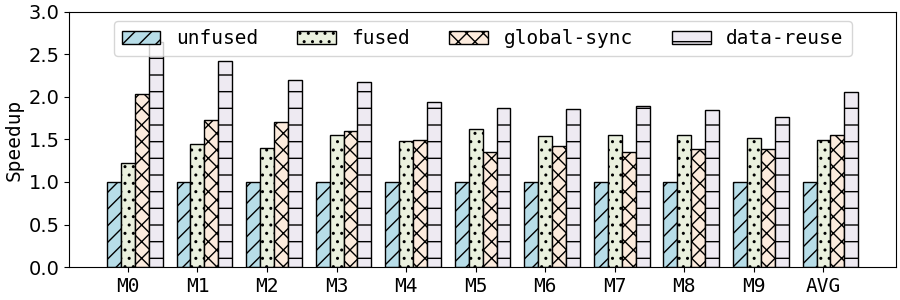

In [66]:
from IPython.display import Image
Image("results/efficientnet-se-module-latency-ours.png")


The image will be saved in `results/efficientnet-se-module-latency-ours.pdf`.
Please compare it with `Figure6`(on page 11) in the submitted paper.

## Contact
If there are any questions or suggestion, please feel free to drop me an email (scscx@leeds.ac.uk). Many thanks for your feedback!


-----
# The end of this Artifact Evaluation
-----

#### Many thanks for your review, time and efforts on this artifact evaluation.  <br> Many thanks for your understanding and bearing with some inconveniences on this notebook. 
